# Fig 5: Analysis of mean-squared displacement

Here we generate the data for figure 5, which compares the mean-squared displacement between the OU model to a model with division noise

## Setup and Load data

In [2]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

k = 2
lw = 1

1

### Load experimental data

In [3]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);


### Load simulations

In [4]:
sims = CSV.read("./../output/sims_models.csv",DataFrame);
sims_gp = CSV.read("./../output/gp/sims_fig5/preds.csv",DataFrame);
τ_range = unique(sims.τ);
ϕ_range = unique(sims.ϕ);
sort!(sims_gp,:lineage);

ArgumentError: ArgumentError: "./../output/gp/sims_fig5/preds.csv" is not a valid file or doesn't exist

In [4]:
function map_lineage_col!(d1,d2,name)
    d2[:,name] = vcat(
    [
        d1[d1.lineage .==l,name][1]*ones(
            length(
                d2[d2.lineage .==l,:time]
                )
            ) 
    for l in unique(d2.lineage)
    ]
    ...);
end

#map_lineage_col!(sims,sims_gp,:τ);
map_lineage_col!(sims,sims_gp,:lineage_original);
map_lineage_col!(sims,sims_gp,:ϕ);
map_lineage_col!(sims,sims_gp,:D);
map_lineage_col!(sims,sims_gp,:τ);
#sims_gp[:,:ϕ] = 1 .-sims_gp.model 

sims_gp;
CSV.write("./../output/gp/preds_fig5.csv",sims_gp)

UndefVarError: UndefVarError: `sims_gp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
sims_gp

Row,matern32notrend_flucs,matern32notrend_flucs_var,matern32notrend_flucs_x,matern32notrend_flucs_x_var,time,position,linear,lineage,age,lineage_original,ϕ,D,τ
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00730709,1.92087e-10,3.54163e-5,2.8249e-7,0.0,0.0,-0.00730739,1.0,0.0,1.0,0.0001,3.30961e-13,1.0
2,0.0073081,7.69195e-11,-4.88347e-6,9.14202e-8,0.1,0.0,0.000527969,1.0,0.1,1.0,0.0001,3.30961e-13,1.0
3,0.00730677,NaN,-2.20093e-5,9.05882e-8,0.2,0.0,0.00836333,1.0,0.2,1.0,0.0001,3.30961e-13,1.0
4,0.0073037,NaN,-3.90538e-5,9.06681e-8,0.3,0.0,0.0161987,1.0,0.3,1.0,0.0001,3.30961e-13,1.0
5,0.00729902,7.66104e-11,-5.42193e-5,9.10621e-8,0.4,0.0,0.024034,1.0,0.4,1.0,0.0001,3.30961e-13,1.0
6,0.00729291,7.5824e-11,-6.7812e-5,9.09173e-8,0.5,0.0,0.0318694,1.0,0.5,1.0,0.0001,3.30961e-13,1.0
7,0.00728549,NaN,-8.02991e-5,9.07932e-8,0.6,0.0,0.0397048,1.0,0.6,1.0,0.0001,3.30961e-13,1.0
8,0.00727688,NaN,-9.18805e-5,9.09911e-8,0.7,0.0,0.0475401,1.0,0.7,1.0,0.0001,3.30961e-13,1.0
9,0.00726716,7.54487e-11,-0.000102276,9.09235e-8,0.8,0.0,0.0553755,1.0,0.8,1.0,0.0001,3.30961e-13,1.0


## Compare GP to sims in division noise model

Here we check visually that the Gaussian process procedure perserves the structure of growth rates in the division noise model 

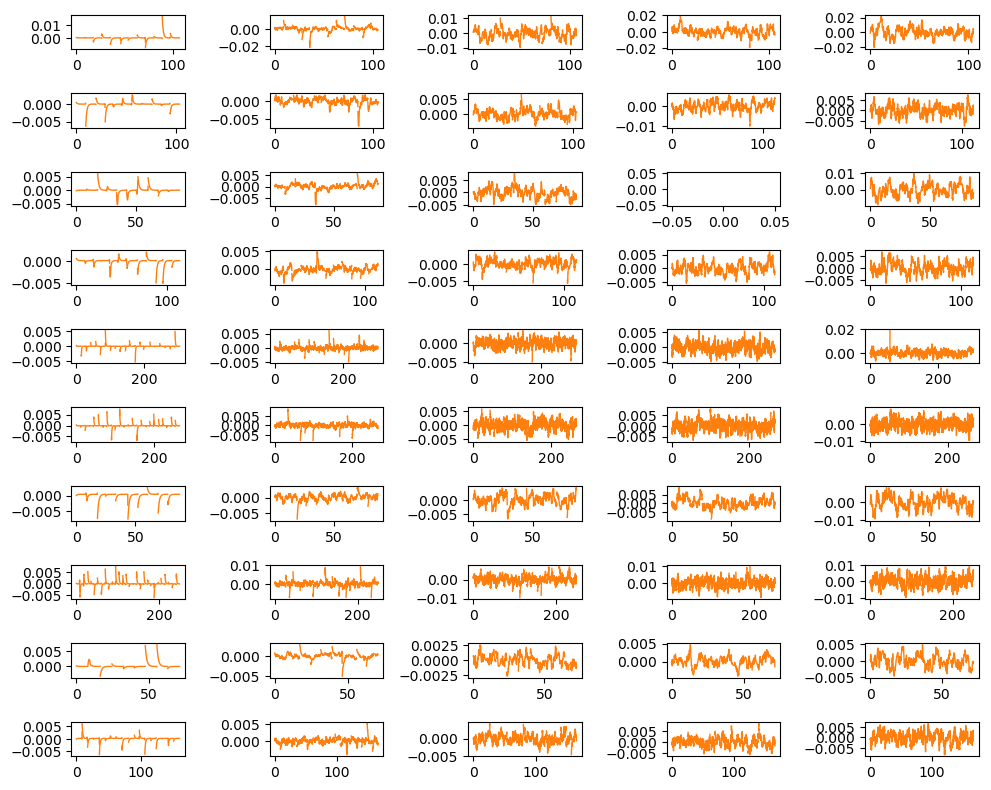

In [5]:
fig, axs= subplots(figsize=(10,8),nrows=length(lineages),ncols=length(ϕ_range))

for k in eachindex(lineages)
    for j in eachindex(ϕ_range)
        ax = axs[k-1,j-1]
        d = sims[sims.lineage_original .== lineages[k],:]
        #d = d[d.τ .== τ_range[1],:]
        d = d[d.ϕ .== ϕ_range[j],:]
        d = d[d.replicate .==1,:];
        dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];
        z = d.λ .- mean(d.λ)
        for p in unique(d.position)
            ax.plot(dgp[dgp.position .== p,:].time,dgp[dgp.position .== p,:].matern32notrend_flucs_x,"C1-",lw=lw)
        end
    end
end
tight_layout()
fig

## Mean-squared displacement comparison 

### MSD Setup 

In [7]:
function MSD(x,max_steps)
    n = length(x)
    msd = zeros(max_steps)
    for i in 1:max_steps 
        msd[i] = mean((x[1:end-i] .- x[i+1:end]).^2)
    end
    return msd
end

function make_msd_dataframe(df,steps,col)
    msd_all = MSD(df[:,col],steps)
    msd_within = mean(hcat([MSD(df[df.position .==p,col],steps) for p in unique(df.position)]...),dims=2)[:,1]
    dt = mean(diff(df[:,:time]))
    times = collect(0:1:(steps-1))*dt
    ratio = (msd_within ) ./ (msd_all)
    dict = Dict(:msd_all => msd_all,:msd_within => msd_within,:lag => times,:ratio => ratio)
    msf_df = DataFrame(dict)
end


function apply_msd_to_groups(df, steps, col, group_col)
    # Define a wrapper function to pass to combine
    function msd_per_group(sub_df)
        return make_msd_dataframe(sub_df, steps, col)
    end

    # Use combine to apply the function to each group and concatenate the results
    combined_df = combine(groupby(df, group_col), msd_per_group)

    return combined_df
end


apply_msd_to_groups (generic function with 1 method)

In [8]:
steps = 100
msd_sims = apply_msd_to_groups(sims_gp, steps,"matern32notrend_flucs_x", :lineage);
msd_data = apply_msd_to_groups(data_gp, steps,"matern32_flucs_x", :lineage);

# add original information to msd_sims
lineage_map = l -> Array(sims[sims.lineage .== l,[:ϕ,:lineage_original]])[1,:]
msd_sims = hcat(msd_sims,DataFrame(hcat(lineage_map.(msd_sims.lineage)...)',[:ϕ,:lineage_original]))
CSV.write("./../output/msd_sims.csv",msd_sims)
CSV.write("./../output/msd_data.csv",msd_data)


"./../output/msd_data.csv"

### Make MSD Figure

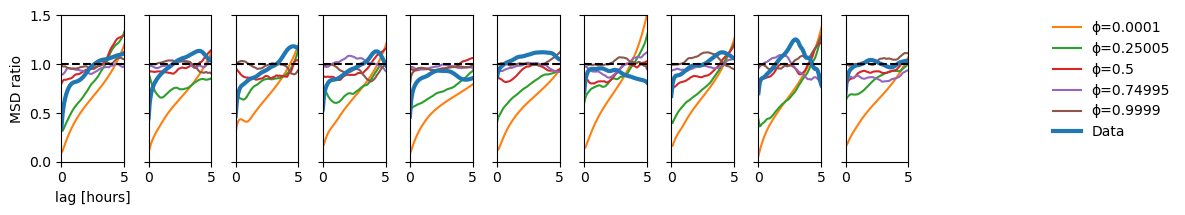

In [9]:
fig, axs= subplots(figsize=(9,2),ncols=length(lineages),nrows=1,sharex=true,sharey=true)
for k in eachindex(lineages)

    ax = axs[k-1]

    # first get the raw simulation dataframe we want 
    d = sims[sims.lineage_original .== lineages[k],:]
    #d = d[d.τ .== τ_range[1],:]
    d = d[d.replicate .==1,:];
    
    
    # ----------------------------------------------------------------------
    for i in eachindex(ϕ_range)
        dm = msd_sims[msd_sims.lineage.== d[d.ϕ .== ϕ_range[i],:].lineage[1],:];
        # plot MSD ratio 
        ax.plot(dm.lag,dm.ratio,"C"*string(i)*"-",label="ϕ="*string(ϕ_range[i]))
    end



    # ----------------------------------------------------------------------
    # DATA
    dd = data_gp[data_gp.lineage.== lineages[k],:]
    msd_df = make_msd_dataframe(dd,steps,"matern32_flucs_x") 

    # plot MSD ratio 
    ax.plot(msd_df.lag,msd_df.ratio,"C0-",label="Data",lw=3)



    # dd = data_gp[data_gp.lineage.== lineages[k],:]
    # m1 = MSD(dd.matern32_flucs_x,steps)
    # m2 = mean(hcat([MSD(dd[dd.position .== p,:].matern32_flucs_x,steps) for p in unique(dd.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C5-",label="data")


    

    #ax = axs[k-1]
    # d = sims[sims.lineage_original .== lineages[k],:]
    # d = d[d.τ .== τ_range[1],:]
    # d = d[d.model .== 0,:]
    # d = d[d.replicate .==1,:];
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];

    # ------------------------------------------------------------------------------------
    # dgp = sims_gp[sims_gp.lineage.== d.lineage[k],:];
    # m1 = MSD(dgp.matern32notrend_flucs_x,steps)
    # m2 = mean(hcat([MSD(dgp[dgp.position .== p,:].matern32notrend_flucs_x,steps) for p in unique(dgp.position)]...),dims=2)[:,1]
    # r = m1 ./ m2
    # ax.plot(r,"C4--",label="OU")
    ax.plot(msd_df.lag,ones(steps),"k--")
    ax.set_xlim([0,5])

end
tight_layout()
axs[-1].legend(frameon=false,bbox_to_anchor=(3.1, 1.05))
axs[0].set_xlabel("lag [hours]")
axs[0].set_ylabel("MSD ratio")
axs[0].set_ylim([0,1.5])
fig

# Variance scaling

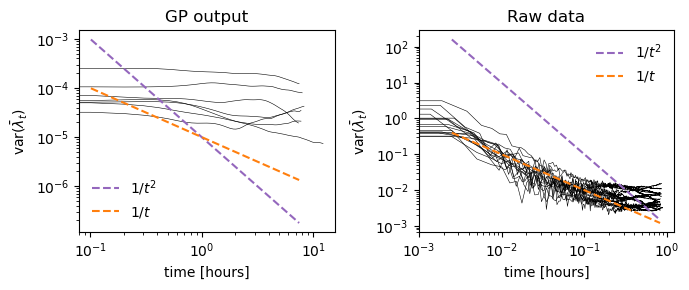

In [18]:
dfs = groupby(data_gp[data_gp.length .> 10,:],:lineage)

fig,axs = subplots(figsize=(7,3),ncols=2)


ax = axs[0]
ax.set_title("GP output")
for D in dfs
    ds = [Matrix(d[:,[:matern32_flucs,:age]]) for d in groupby(D,:position)]
    maxind = min([length(d[:,1]) for d in ds]...)
    tmax = min([maximum(d[:,2]) for d in ds]...)
    ds = hcat([(d[2:maxind,1] .- d[1,1]) ./d[2:maxind,2] for d in ds]...)
    trang = LinRange(0,tmax,maxind-1)
    ax.loglog(trang,var(ds,dims=2),"k-",alpha=1.,lw=0.4)
end

ds = [Matrix(d[:,[:matern32_flucs,:age]]) for d in groupby(dfs[1],:position)]
maxind = min([length(d[:,1]) for d in ds]...)
tmax = min([maximum(d[:,2]) for d in ds]...)
trang = LinRange(0,tmax,maxind-1)
ax.plot(trang,0.00001 ./ trang .^2,"C4--",label=L"$1/t^2$")
ax.plot(trang,0.00001 ./ trang,"C1--",label=L"$1/t$")
ax.legend(frameon=false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")


ax = axs[1]

ax.set_title("Raw data")

dfs = groupby(data_raw[data_raw.length .> 5,:],:lineage)
for D in dfs # for each lineage
    ds = [Matrix(d[:,[:lnM,:age]]) for d in groupby(D,:position)] # split up lineage by cell position
    maxind = min([length(d[:,1]) for d in ds]...) # find the minimum length of the lineage
    tmax = min([maximum(d[:,2]) for d in ds]...) # find the final time to plot

    # now I make a matrix of ln M(t) - ln M(0) for each cells and plot the variance over cells
    ds = hcat([(d[2:maxind,1] .- d[1,1]) ./d[2:maxind,2] for d in ds]...)
    trang = LinRange(0,tmax,maxind-1)
    ax.loglog(trang,var(ds,dims=2),"k-",alpha=1.,lw=0.4) # plot the variance over the 
end

ds = [Matrix(d[:,[:lnM,:age]]) for d in groupby(dfs[1],:position)]
maxind = min([length(d[:,1]) for d in ds]...)
tmax = min([maximum(d[:,2]) for d in ds]...)
trang = LinRange(0,tmax,maxind-1)
ax.plot(trang,0.001 ./ trang .^2,"C4--",label=L"$1/t^2$")
ax.plot(trang,0.001 ./ trang,"C1--",label=L"$1/t$")
ax.legend(frameon=false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")
tight_layout()
savefig("./../output/fig5_scaling.pdf")
fig


In [16]:

dfs = groupby(sims_gp[sims_gp.ϕ .==phirang[end],:],:lineage)

fig,ax = subplots(figsize=(5,3),sharey=true)


ax.set_title("Simulated data")
for D in dfs
    ds = [Matrix(d[:,[:matern32notrend_flucs,:age]]) for d in groupby(D,:position)]
    maxind = min([length(d[:,1]) for d in ds]...)
    tmax = min([maximum(d[:,2]) for d in ds]...)
    ds = hcat([d[2:maxind,1] ./d[2:maxind,2] for d in ds]...)
    trang = LinRange(0,tmax,maxind-1)
    ax.loglog(trang,var(ds,dims=2),"k-",alpha=1.,lw=0.4)
end

ds = [Matrix(d[:,[:matern32notrend_flucs,:age]]) for d in groupby(dfs[1],:position)]
maxind = min([length(d[:,1]) for d in ds]...)
tmax = min([maximum(d[:,2]) for d in ds]...)
trang = LinRange(0,tmax,maxind-1)
ax.plot(trang,0.01 ./ trang .^2,"C4--",label=L"$1/t^2$")
ax.plot(trang,0.3 ./ trang,"C1--",label=L"$1/t$")
ax.legend(frameon=false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")

fig

UndefVarError: UndefVarError: `phirang` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
dfs = groupby(data_gp,:lineage)

fig,axs = subplots(figsize=(5,2),ncols=2,sharey=true)


ax = axs[0]
ax.set_title("GP output")
for D in dfs
    ds = [Matrix(d[:,[:matern32_flucs,:age]]) for d in groupby(D,:position)]
    maxind = min([length(d[:,1]) for d in ds]...)
    tmax = min([maximum(d[:,2]) for d in ds]...)
    ds = hcat([(d[2:maxind,1] .- d[1,1]) ./d[2:maxind,2] for d in ds]...)
    trang = LinRange(0,tmax,maxind-1)
    ax.loglog(trang,var(ds,dims=2),"k-",alpha=1.,lw=0.4)
end

ds = [Matrix(d[:,[:matern32_flucs,:age]]) for d in groupby(dfs[1],:position)]
maxind = min([length(d[:,1]) for d in ds]...)
tmax = min([maximum(d[:,2]) for d in ds]...)
trang = LinRange(0,tmax,maxind-1)
ax.plot(trang,0.001 ./ trang .^2,"C4--",label=L"$1/t^2$")
ax.plot(trang,0.001 ./ trang,"C1--",label=L"$1/t$")
ax.legend(frameon=false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")


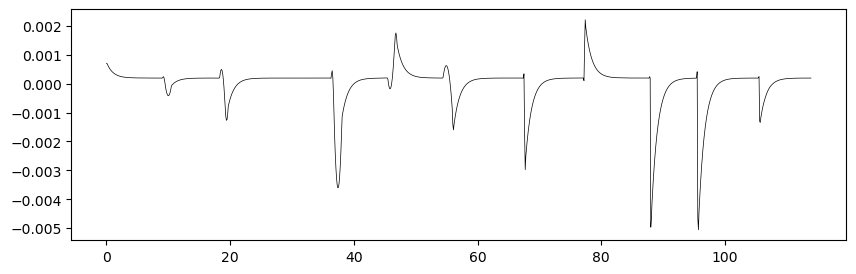

In [117]:
fig,ax = subplots(figsize=(10,3))
df1 = dfs[4]
ax.plot(df1.time,df1.matern32notrend_flucs_x,"k-",lw=0.5)
fig

In [15]:

dfs = groupby(sims[sims.ϕ .==phirang[end],:],:lineage)

fig,ax = subplots(figsize=(5,3),sharey=true)


ax.set_title("Simulated data")
for D in dfs[1:4]
    ds = [Matrix(d[:,[:lnM,:age]]) for d in groupby(D,:position)]
    maxind = min([length(d[:,1]) for d in ds]...)
    tmax = min([maximum(d[:,2]) for d in ds]...)
    ds = hcat([d[2:maxind,1] ./d[2:maxind,2] for d in ds]...)
    trang = LinRange(0,tmax,maxind-1)
    ax.loglog(trang,var(ds,dims=2),"k.",alpha=1.,lw=0.4)
end

ds = [Matrix(d[:,[:lnM,:age]]) for d in groupby(dfs[1],:position)]
maxind = min([length(d[:,1]) for d in ds]...)
tmax = min([maximum(d[:,2]) for d in ds]...)
trang = LinRange(0,tmax,maxind-1)
ax.plot(trang,0.01 ./ trang .^2,"C4--",label=L"$1/t^2$")
ax.plot(trang,0.3 ./ trang,"C1--",label=L"$1/t$")
ax.legend(frameon=false)
ax.set_xlabel("time [hours]")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")

fig

UndefVarError: UndefVarError: `phirang` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

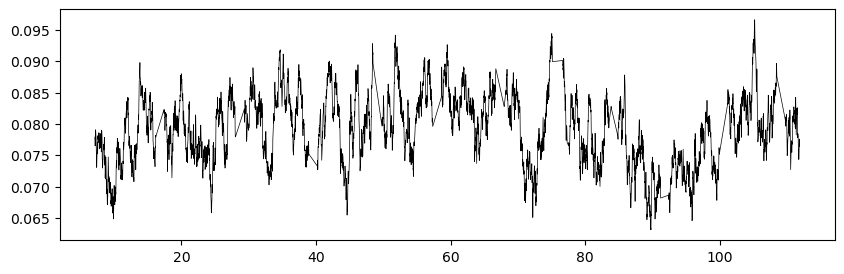

In [129]:
fig,ax = subplots(figsize=(10,3))
df1 = dfs[4]
ax.plot(df1.time,df1.λ,"k-",lw=0.5)
fig